# Wasserstein GAN & Improved Wasserstein GAN

이번에는 WGAN이라고도 불리는 Wasserstein GAN을 tensorflow 2로 구현해볼 것입니다.
WGAN에는 두가지 버전(?)이 있는데요, 물론 더 많은 버전이 있겠지만, 다음 두 가지 버전을 구현해 볼 것입니다.
- WGAN with weight clipping
- WGAN with gradient penalty

## Introduction to WGAN

WGAN의 원 논문에서는 GAN의 문제점을 다음과 같이 지적합니다.

고차원 이미지 공간의 latent를 학습하는 manifold learning에서, 저차원의 노이즈 신호로부터 고차원의 이미지를 복원하려는 과정 속에서 실제 우리가 관심있는 이미지 공간은 노이즈가 복원한 이미지 공간과 겹칠 가능성은 거의 0에 수렴합니다. 하지만, GAN은 KL-divergence로 실제 이미지의 분포와 복원된 이미지 분포 사이의 거리를 최소화하는 것이죠. 아시는 분들은 아시다시피, KL-divergence는 두 분포 사이의 거리를 계산해주는 지표인데, 두 분포가 겹치지 않는다면 두 분포 사이의 거리는 $\infty$입니다.

실제로, 고차원 공간에서 실제 이미지 분포와 복원된 이미지 분포가 거의 겹치지 않을 가능성이 크므로, KL-divergence는 GAN을 학습하기 위한 거리 metric으로 적합하지 않다는 것입니다. WGAN에서는 이를 해결하기 위해, 이미지 분포간 거리를 KL-divergence 말고 EM distance(Earth mover distance)를 사용할 것을 제안합니다.

하지만, EM distance는 고차원 이미지 공간에서 합리적인 시간 내에 계산이 불가능합니다. 하지만, duality 같은 것들을 이용하여 쉬운문제로 바꿔서 내린 결론은, discriminator가 1-lipshitz(립쉬츠) 함수이기만 하면 원래 GAN loss를 사용해서 학습을 해도 EM distance를 최소화하는 것과 같다는 것입니다.

그러니까, 원래 GAN loss에서 discriminator가 1-lipshitz 함수임을 만족시키는 제약조건을 하나 넣어주면 된다는 것입니다.
$$
\underset{\theta}{\text{argmax }} \underset{\phi}{\text{argmin }} [E[D_{\phi}(x_{real})] - E[D_{\phi}(G_{\theta}(z))]] \\
\text{s.t } D = \text{1-lipshitz}
$$

최초의 GAN논문에서는 이것을 위해 discriminator의 weight를 $[-0.01, 0.01]$로 clipping 하게 되면 일단 1-lipshitz 함수를 만족한다고 하고, weight clipping을 사용합니다.
하지만, weight-clipping은 clipping으로 인해, momentum-based optimizer를 사용할 수 없으며, 불안정하게 됩니다. 따라서, 낮은 learning rate의 RMS-prop을 사용하게 됩니다. 또한, weight clipping을 통해 얻을 수 있는 discriminator는 1-lipshitz함수의 극히 일부이며, 이는 weight clipping을 한 discriminator가 최적의 1-lipshitz함수가 아닐 수 있다는 문제점이 있습니다.

**길게 이론을 적긴 했으나, 구현 측면에서의 문제점은 다음과 같습니다.**
- 실제 이미지 분포와 생성된 이미지 분포가 거의 겹치지 않으므로, discriminator가 빠른 속도로 완벽하게(정확도 거의 100%) 학습되게 됩니다.
- 생성된 이미지에 대해서는 거의 100% fake라고 판단하고, 실제 이미지에 대해서는 0%로 fake라고 판단하게 되며, **이는 generator의 gradient vanishing을 발생시킵니다**.

## Improved WGAN

WGAN은 성능은 괜찮았지만, weight clipping으로 발생하는 여러가지 문제점이 있었습니다. 이를 해결하기 위해서는 weight clipping 대신 다른 방법을 통해 discriminator를 1-lipshitz 함수로 만들어야 합니다. Clipping이 없어지므로 momentum-based optimizer를 사용할 수 있고, learning rate도 정상적으로(?) 줄 수 있습니다.

"Improved Training of Wasserstein GANs"이라는 논문에서는 weight clipping 대신 gradient penalty를 이용해서 discriminator가 1-lipshitz 함수임을 만족시키도록 하는 것을 제안합니다.

Loss는 다음과 같게 됩니다.
$$
\underset{\theta}{\text{argmax }} \underset{\phi}{\text{argmin }} [E[D_{\phi}(x_{real})] - E[D_{\phi}(G_{\theta}(noise))]] - \lambda \cdot (\nabla D_{\phi}(\hat{x}) - 1)^2
$$

맨 마지막 term이 gradient penalty를 나타내는데요, $\hat{x}$는 실제 이미지와 생성된 이미지 사이의 내분점입니다.. 구현이 어떻게 되는지는 밑에 있습니다.

## Adventage of WGAN

WGAN을 이용하여 GAN을 구현하게 되면 좋은 점은 다음과 같습니다.
1. Generator의 gradient가 NaN이 되는 현상이 줄어듦
2. 기존 GAN은 학습이 잘 안됨. 정말 안됨. WGAN을 적용하면 좀 많이 나아짐

## Implementation

먼저 모듈을 import합니다.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers, optimizers, losses, metrics, datasets

Batch size와 epochs를 설정합니다.

In [3]:
BATCH_SIZE = 256

MNIST를 사용할 겁니다. 편의를 위해 이것을 tf.data.Dataset으로 바꿔줍니다.

In [4]:
trainset, testset = datasets.mnist.load_data()

In [5]:
trainloader = tf.data.Dataset.from_tensor_slices(trainset).batch(BATCH_SIZE).shuffle(4096)
testloader = tf.data.Dataset.from_tensor_slices(testset).batch(BATCH_SIZE)

### Generative Adversarial Network Architecture

다음은 일반적인 GAN의 구현입니다. WGAN은 그저 loss함수와 학습할때의 과정이 조금 다를 뿐, GAN 아키텍쳐 자체는 건들지 않습니다.

In [6]:
class DeepConvolutionGAN(models.Model):
    
    def __init__(self):
        super(DeepConvolutionGAN, self).__init__()
        
        self.generator = models.Sequential([
            layers.Conv2DTranspose(32, (3, 3), strides=(1, 1), padding="SAME", output_padding=0),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding="SAME", output_padding=1),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.relu),
            
            layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding="SAME", output_padding=0),
            layers.Activation(tf.nn.sigmoid),
        ])
        
        self.discriminator = models.Sequential([
            
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(64, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(32, (3, 3), strides=(2, 2), padding="SAME"),
            layers.BatchNormalization(),
            layers.Activation(tf.nn.leaky_relu),
            
            layers.Conv2D(1, (3, 3), strides=(2, 2), padding="SAME"),
            layers.Activation(tf.nn.sigmoid),
        ])
        
    def call(self, x=None, training=False):
        if x is None:
            n = 1
        else:
            n = tf.shape(x)[0]
            
        noise = tf.random.normal((n, 7, 7, 16))
        
        x_generated = self.generator(noise, training=training)
        
        if training is True:
            d_real = self.discriminator(x, training=training)
            d_fake = self.discriminator(x_generated, training=training)
            
            return x_generated, d_real, d_fake
        
        return x_generated

### WGAN

In [7]:
model_wc = DeepConvolutionGAN()
optimizer_rms_gen = optimizers.RMSprop(learning_rate=1e-3)
optimizer_rms_dis = optimizers.RMSprop(learning_rate=1e-5)

EPOCHS = 500

# binary cross entropy
bce_criterion = losses.BinaryCrossentropy()

# loss를 축적해서 나중에 평균내주는 편리한 객체들
gen_loss_obj = metrics.Mean()
dis_loss_obj = metrics.Mean()

In [8]:
def wgan_weight_clipping():
    """
    WGAN의 weight clipping을 구현한 것
    
    Arguments:
    ----------
    - model GAN 모델 객체
    """
    
    for i in range(len(model_wc.trainable_variables)):
        model_wc.trainable_variables[i] = tf.clip_by_value(model_wc.trainable_variables[i], -0.01, 0.01)

In [9]:
def train_step_wgan(x_real, y):
    """
    training 1 batch-step
    
    Arguments:
    ----------
    - model GAN 객체
    - x_real 4차원 텐서. 실제 이미지 배치 (BATCH_SIZE, 28, 28, 1)
    - mode "gp" or "wc" (gradient penalty는 gp, weight clipping은 wc)
    """
    
    # 배치 크기 계산
    n = tf.shape(x_real)[0]
    
    # loss 초기화
    loss_gen = 0.0
    loss_dis = 0.0
    
    with tf.GradientTape(persistent=True) as tape:
        x_generated, d_real, d_generated = model_wc(x_real, training=True)

        # generator loss of gan
        loss_gen += bce_criterion(tf.ones((n,)), d_generated)

        loss_dis += bce_criterion(tf.ones((n,)), d_real)
        loss_dis += bce_criterion(tf.zeros((n,)), d_generated)

    # generator update
    grads_gen = tape.gradient(loss_gen, model_wc.generator.trainable_variables)
    optimizer_rms_gen.apply_gradients(zip(grads_gen, model_wc.generator.trainable_variables))

    # discriminator update
    grads_dis = tape.gradient(loss_dis, model_wc.discriminator.trainable_variables)
    optimizer_rms_dis.apply_gradients(zip(grads_dis, model_wc.discriminator.trainable_variables))
    
    # weight clipping은 discriminator를 업데이트 한번 한 후 시행
    wgan_weight_clipping()

    # loss 축적
    gen_loss_obj.update_state(loss_gen)
    dis_loss_obj.update_state(loss_dis)

In [10]:
def test_step_wgan():
    
    plt.figure(figsize=(16, 2), dpi=120)
    for i, ind in enumerate(np.random.randint(0, 10, size=10)):
        generated = model_wc(None, training=False)
        image = generated.numpy().reshape(28, 28)
        
        plt.subplot(1, 10, i+1)
        plt.imshow(image, cmap="gray")
    
    plt.show()

In [11]:
def train_wgan():
    """
    GAN 학습
    """
    
    for e in range(EPOCHS):
        for x, y in trainloader:
            x_batch = tf.cast(x, dtype=tf.float32)/256
            x_batch = tf.expand_dims(x_batch, axis=-1)
            y_batch = tf.cast(y, dtype=tf.float32)
            train_step_wgan(x_batch, y_batch)
            
        gen_loss = gen_loss_obj.result()
        dis_loss = dis_loss_obj.result()
        gen_loss_obj.reset_states()
        dis_loss_obj.reset_states()

        if e == 0 or (e+1)%100 == 0:
            print(f"Epochs {e+1}/{EPOCHS}, generator loss: {gen_loss:.8f}, discriminator loss: {dis_loss:.8f}")
            test_step_wgan()

Epochs 1/500, generator loss: 0.15103284, discriminator loss: 2.80615973


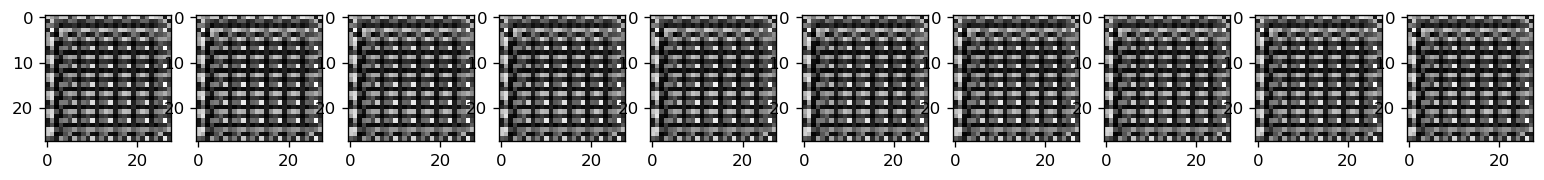

Epochs 100/500, generator loss: 1.60395515, discriminator loss: 0.70765054


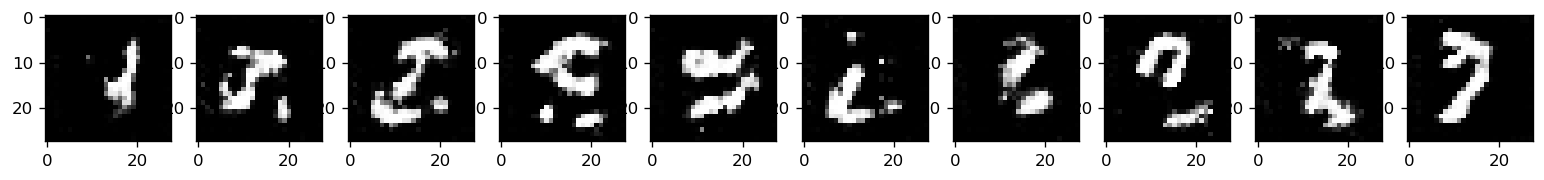

Epochs 200/500, generator loss: 3.73429942, discriminator loss: 0.17158656


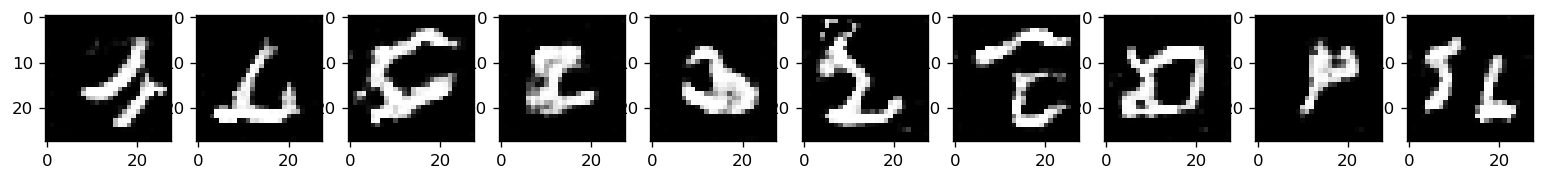

Epochs 300/500, generator loss: 5.35343266, discriminator loss: 0.06669513


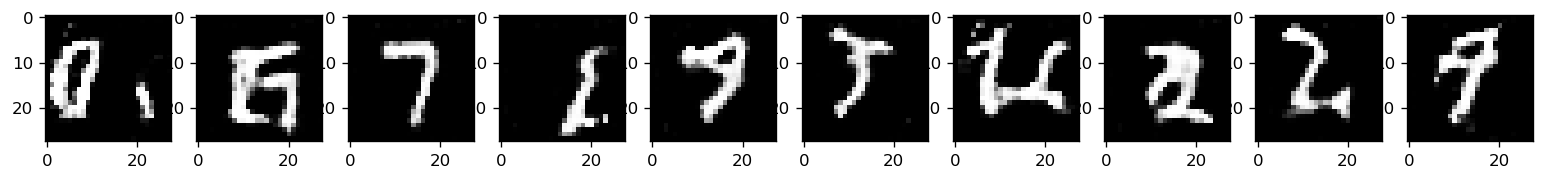

Epochs 400/500, generator loss: 6.37775755, discriminator loss: 0.02266556


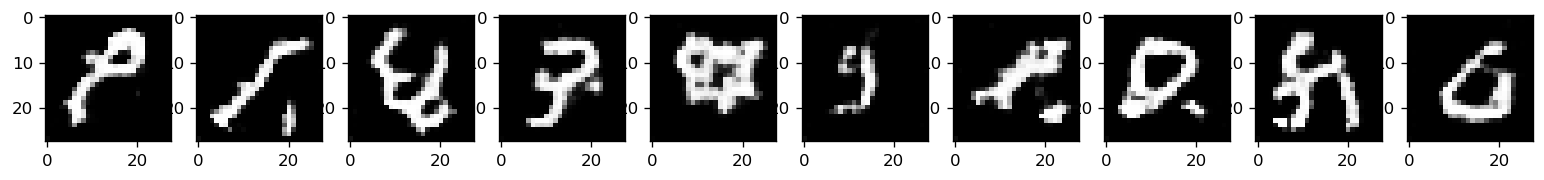

Epochs 500/500, generator loss: 7.32676888, discriminator loss: 0.00973613


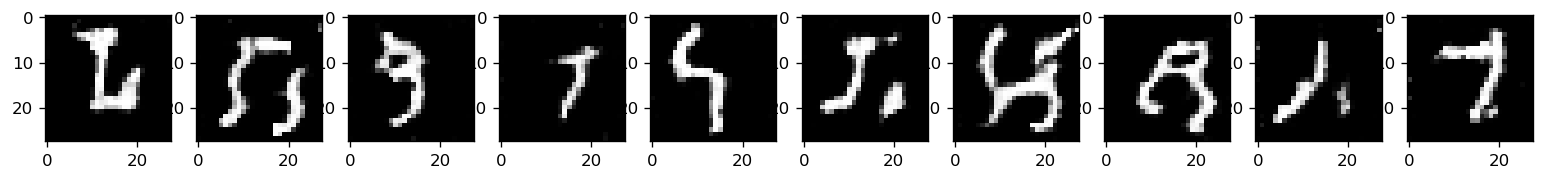

In [12]:
train_wgan()

### WGAN with Gradient Penalty

In [13]:
# GAN 객체 생성 (gp for gradient penalty, wc for weight clipping)
model_gp = DeepConvolutionGAN()

EPOCHS = 500

# ADAM은 gradient penalty를 사용할때 사용, RMS prop은 weight clipping을 사용할때 사용
optimizer_adam = optimizers.Adam(learning_rate=1e-3)

# binary cross entropy
bce_criterion = losses.BinaryCrossentropy()

# loss를 축적해서 나중에 평균내주는 편리한 객체들
gen_loss_obj = metrics.Mean()
dis_loss_obj = metrics.Mean()

In [14]:
def wgan_gradient_penalty(x_real, x_fake, n_samples=10):
    """
    WGAN의 gradient penalty를 구현한 것
    
    Arguments:
    ----------
    - x_real 4차원 텐서. 실제 이미지 배치 (BATCH_SIZE, 28, 28, 1)
    - x_fake 4차원 텐서. 생성된 이미지 배치 (BATCH_SIZE, 28, 28, 1)
    - n_samples gradient penalty를 몇 번 계산할 것인지에 대한 상수, 많을수록 gradent penalty 효과가 좋음
    
    Returns:
    --------
    - gp gradient penalty를 계산한 것
    """
    
    n = tf.shape(x_real)[0]
    
    # 내분점을 만들기 위한 0~1사이의 수
    r = tf.random.uniform((n_samples, n, 1, 1, 1), minval=0, maxval=1)
    
    # 내분점
    x_sample = tf.expand_dims(x_real, axis=0)*r + tf.expand_dims(x_fake, axis=0)*(1 - r)
    x_sample = tf.reshape(x_sample, shape=(n_samples*n, 28, 28, 1))
    
    # 내분점 이미지를 discriminator에 통과시킴
    with tf.GradientTape() as tape:
        tape.watch(x_sample)                              # gradient tape가 x_sample도 gradient를 계산하는 대상으로 주시하라는 의미
        d = model_gp.discriminator(x_sample, training=True) # 내분점 이미지 x_sample를 discriminator에 통과시킴
        
    # discriminator 결과를 내분점 이미지에 대해 미분
    grads = tape.gradient(d, x_sample)
    
    # 펼치고
    grads_flatten = tf.reshape(grads, shape=(n, -1))
    
    # norm을 계산해서
    grads_norm = tf.norm(grads_flatten, axis=1)
    
    # 이 norm이 1에 가깝게 학습되도록 loss 생성
    gp = tf.reduce_mean((grads_norm - 1)**2)
    
    return gp

In [15]:
def train_step_wgan_gp(x_real, y):
    """
    training 1 batch-step
    
    Arguments:
    ----------
    - model GAN 객체
    - x_real 4차원 텐서. 실제 이미지 배치 (BATCH_SIZE, 28, 28, 1)
    - mode "gp" or "wc" (gradient penalty는 gp, weight clipping은 wc)
    """
    
    # 배치 크기 계산
    n = tf.shape(x_real)[0]
    
    # loss 초기화
    loss_gen = 0.0
    loss_dis = 0.0
    
    # generator를 1번 학습
    with tf.GradientTape(persistent=True) as tape:
        x_generated, d_real, d_generated = model_gp(x_real, training=True)

        # generator loss of gan
        loss_gen += bce_criterion(tf.ones((n,)), d_generated)

        loss_dis += bce_criterion(tf.ones((n,)), d_real)
        loss_dis += bce_criterion(tf.zeros((n,)), d_generated)

        # gradient penalty를 사용하려면, discriminator의 loss에 gradient penalty를 더해주어야 함
        gp = wgan_gradient_penalty(x_real, x_generated, n_samples=10)
        loss_dis += 10*tf.reduce_mean(gp)

    # generator update
    grads_gen = tape.gradient(loss_gen, model_gp.generator.trainable_variables)
    optimizer_adam.apply_gradients(zip(grads_gen, model_gp.generator.trainable_variables))
    
    # discriminator update
    grads_dis = tape.gradient(loss_dis, model_gp.discriminator.trainable_variables)
    optimizer_adam.apply_gradients(zip(grads_dis, model_gp.discriminator.trainable_variables))

    # loss 축적
    gen_loss_obj.update_state(loss_gen)
    dis_loss_obj.update_state(loss_dis)

In [16]:
def test_step_wgan_gp():
    
    plt.figure(figsize=(16, 2), dpi=120)
    for i, ind in enumerate(np.random.randint(0, 10, size=10)):
        generated = model_gp(None, training=False)
        image = generated.numpy().reshape(28, 28)
        
        plt.subplot(1, 10, i+1)
        plt.imshow(image, cmap="gray")
    
    plt.show()

In [17]:
def train_wgan_gp():
    """
    GAN 학습
    """
    
    for e in range(EPOCHS):
        for x, y in trainloader:
            x_batch = tf.cast(x, dtype=tf.float32)/256
            x_batch = tf.expand_dims(x_batch, axis=-1)
            y_batch = tf.cast(y, dtype=tf.float32)
            train_step_wgan_gp(x_batch, y_batch)
            
        gen_loss = gen_loss_obj.result()
        dis_loss = dis_loss_obj.result()
        gen_loss_obj.reset_states()
        dis_loss_obj.reset_states()

        if e == 0 or (e+1)%100 == 0:
            print(f"Epochs {e+1}/{EPOCHS}, generator loss: {gen_loss:.8f}, discriminator loss: {dis_loss:.8f}")
            test_step_wgan_gp()

Epochs 1/500, generator loss: 0.55459082, discriminator loss: 6.66883421


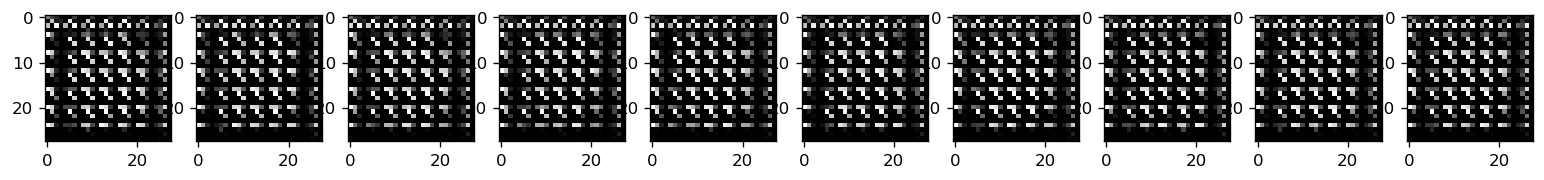

Epochs 100/500, generator loss: 1.02284539, discriminator loss: 1.13844228


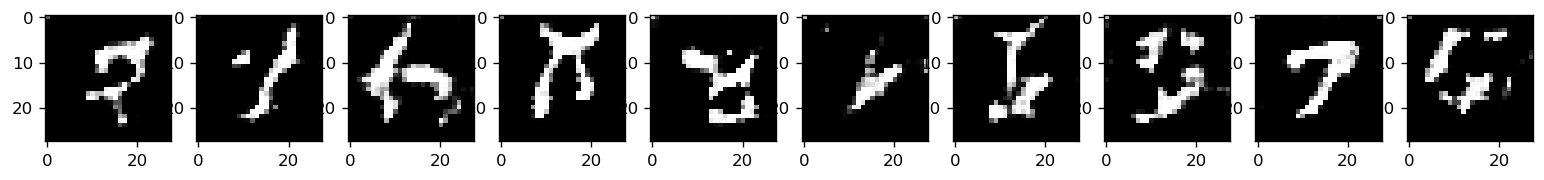

Epochs 200/500, generator loss: 5.24670410, discriminator loss: 0.05830562


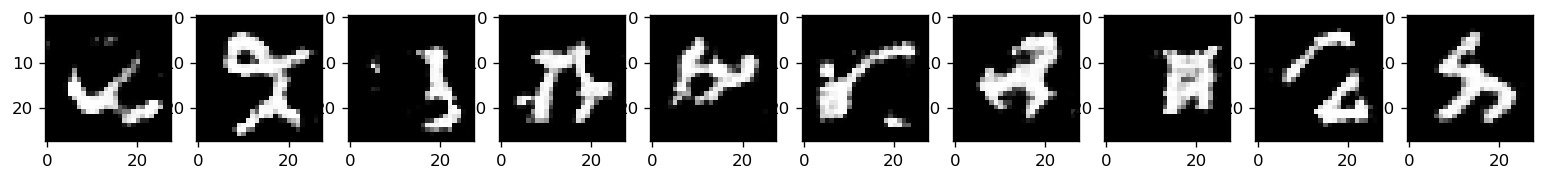

Epochs 300/500, generator loss: 6.05137634, discriminator loss: 0.02943799


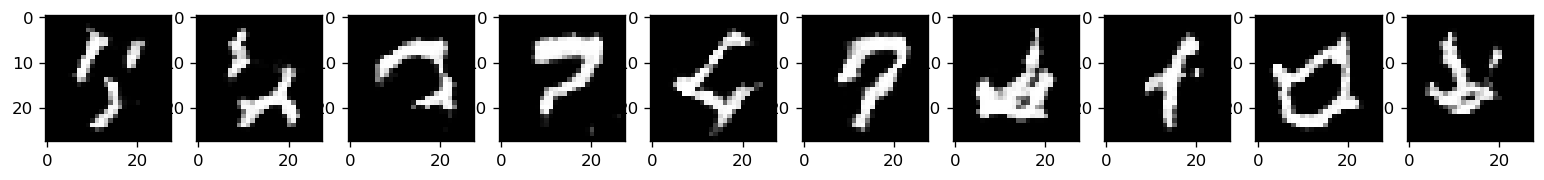

Epochs 400/500, generator loss: 7.50551653, discriminator loss: 0.01404314


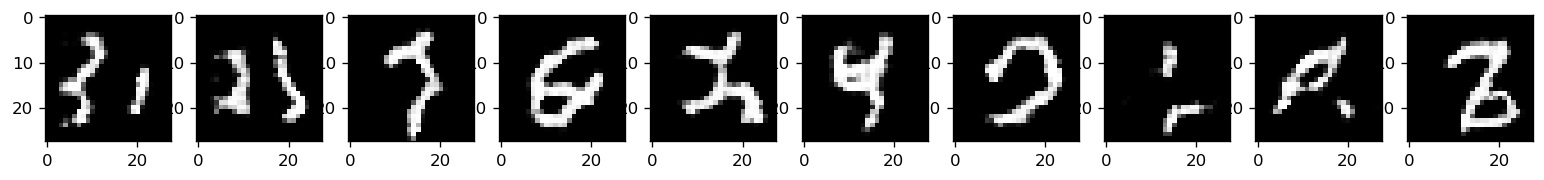

Epochs 500/500, generator loss: 8.48253155, discriminator loss: 0.02181518


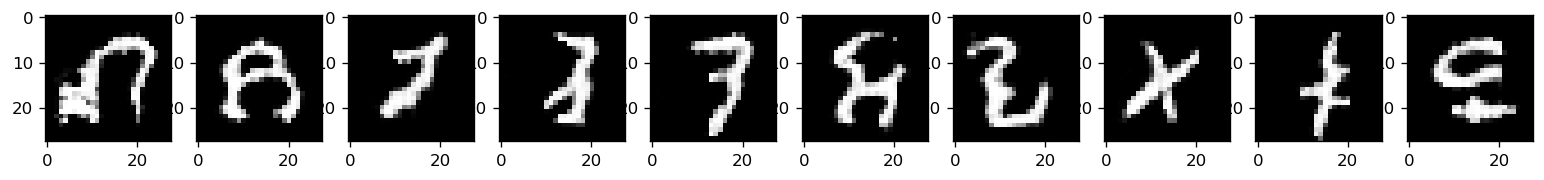

In [18]:
train_wgan_gp()

## References

- [Wasserstein GAN](https://arxiv.org/abs/1701.07875)
- [Improved Training of Wasserstein GANs](https://arxiv.org/abs/1704.00028)